In [1]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
# import keras_metrics as km
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
import math

In [2]:
data_dir = "/content/drive/MyDrive/video_data"
img_height , img_width = 64, 64
seq_len = 16

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
classes = ["fall", "fall_down", "grab", "swallow", "walk","sit"]

In [9]:
def frames_extraction(video_path):
    frames_list = []
     
    vidcap = cv2.VideoCapture(video_path)
    total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

    frames_step = total_frames//seq_len
 
    for j in range(seq_len):
        #here, we set the parameter 1 which is the frame number to the frame (i*frames_step)
        vidcap.set(1,j*frames_step)
        success,image = vidcap.read()  
        #save your image
        if success:
          image = cv2.resize(image, (img_height, img_width))
          frames_list.append(image)
        else:
          print("Defected frame {}".format(video_path))
          break

    return frames_list

In [10]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [16]:
X, Y = create_data(data_dir)
 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

walk
fall_down
swallow
Defected frame /content/drive/MyDrive/video_data/swallow/70.mov
Defected frame /content/drive/MyDrive/video_data/swallow/81_crop (online-video-cutter.com).mp4
Defected frame /content/drive/MyDrive/video_data/swallow/83_crop (online-video-cutter.com).mp4
Defected frame /content/drive/MyDrive/video_data/swallow/80 (online-video-cutter.com).mp4
Defected frame /content/drive/MyDrive/video_data/swallow/79_crop (online-video-cutter.com).mp4
Defected frame /content/drive/MyDrive/video_data/swallow/82_crop (online-video-cutter.com).mp4
fall
grab
Defected frame /content/drive/MyDrive/video_data/grab/110_crop (online-video-cutter.com).mp4
Defected frame /content/drive/MyDrive/video_data/grab/112_crop (online-video-cutter.com).mp4
Defected frame /content/drive/MyDrive/video_data/grab/106_crop (online-video-cutter.com).mp4
Defected frame /content/drive/MyDrive/video_data/grab/109_crop (online-video-cutter.com).mp4
Defected frame /content/drive/MyDrive/video_data/grab/113 (on

In [17]:
model = Sequential()

model.add(ConvLSTM2D(filters = 128, kernel_size = (3, 3),strides = (2,2), return_sequences = True, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3),strides = (2,2), return_sequences = True, data_format = "channels_last"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3),strides = (2,2), return_sequences = False, data_format = "channels_last"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(6, activation = "softmax"))
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 16, 31, 31, 128)   604160    
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 31, 31, 128)   512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 31, 31, 128)   0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 16, 15, 15, 64)    442624    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 15, 15, 64)    256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 15, 15, 64)    0         
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 7, 7, 32)         

In [18]:
def schedular(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * math.exp(0.1*(10-epoch))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1042s 54s/step - loss: 2.7278 - accuracy: 0.1935 - val_loss: 1.7372 - val_accuracy: 0.2649
Epoch 2/20
19/19 [==============================] - 1024s 54s/step - loss: 2.6254 - accuracy: 0.2501 - val_loss: 1.8088 - val_accuracy: 0.1788
Epoch 3/20
19/19 [==============================] - 1022s 54s/step - loss: 2.5748 - accuracy: 0.2024 - val_loss: 1.7409 - val_accuracy: 0.2914
Epoch 4/20
19/19 [==============================] - 1020s 54s/step - loss: 2.4924 - accuracy: 0.2273 - val_loss: 1.7378 - val_accuracy: 0.2715
Epoch 5/20
19/19 [==============================] - 1029s 54s/step - loss: 2.6781 - accuracy: 0.2025 - val_loss: 1.7284 - val_accuracy: 0.2980
Epoch 6/20
19/19 [==============================] - 1021s 54s/step - loss: 2.3903 - accuracy: 0.2258 - val_loss: 1.7947 - val_accuracy: 0.1589
Epoch 7/20
19/19 [==============================] - 1020s 54s/step - loss: 2.3776 - accuracy: 0.2605 - val_loss: 1.6881 - val_accuracy: 0.3377
Epoch 8/20

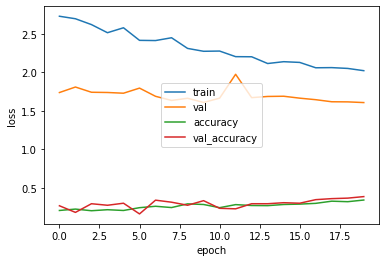

In [19]:
opt = optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=7)
callbacks = tf.keras.callbacks.LearningRateScheduler(schedular)
 
history = model.fit(x = X_train, y = y_train, epochs=20, batch_size = 32, shuffle=True, validation_split=0.2, callbacks=[callbacks])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val','accuracy','val_accuracy'])
plt.show()


In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test) 
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
 
print(classification_report(y_test, y_pred))

print('accuracy score : {}'.format(accuracy_score(y_pred, y_test)))


              precision    recall  f1-score   support

           0       0.71      0.33      0.45        15
           1       0.38      0.38      0.38        55
           2       0.67      0.06      0.11        33
           3       0.69      0.27      0.39        33
           4       0.24      0.76      0.37        34
           5       0.33      0.05      0.09        19

    accuracy                           0.34       189
   macro avg       0.50      0.31      0.30       189
weighted avg       0.48      0.34      0.31       189

accuracy score : 0.3386243386243386
